# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
X_train_feats.shape

(49000, 155)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7,1.05e-7, 1.1e-7,1.15e-7, 1.2e-7]
regularization_strengths = [6.5e5,6.8e5,7e5,7.2e5,7.5e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in learning_rates:
    for j in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats,y_train,learning_rate=i,reg=j)
        train_accuracy = (svm.predict(X_train_feats) == y_train).mean()
        val_accuracy = (svm.predict(X_val_feats) == y_val).mean()
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm
        results[(i,j)] = (train_accuracy,val_accuracy)
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 6.500000e+05 train accuracy: 0.399939 val accuracy: 0.383000
lr 1.000000e-07 reg 6.800000e+05 train accuracy: 0.403694 val accuracy: 0.404000
lr 1.000000e-07 reg 7.000000e+05 train accuracy: 0.392286 val accuracy: 0.397000
lr 1.000000e-07 reg 7.200000e+05 train accuracy: 0.400959 val accuracy: 0.410000
lr 1.000000e-07 reg 7.500000e+05 train accuracy: 0.403265 val accuracy: 0.395000
lr 1.050000e-07 reg 6.500000e+05 train accuracy: 0.399551 val accuracy: 0.399000
lr 1.050000e-07 reg 6.800000e+05 train accuracy: 0.404122 val accuracy: 0.416000
lr 1.050000e-07 reg 7.000000e+05 train accuracy: 0.397898 val accuracy: 0.387000
lr 1.050000e-07 reg 7.200000e+05 train accuracy: 0.399714 val accuracy: 0.413000
lr 1.050000e-07 reg 7.500000e+05 train accuracy: 0.393408 val accuracy: 0.382000
lr 1.100000e-07 reg 6.500000e+05 train accuracy: 0.400612 val accuracy: 0.399000
lr 1.100000e-07 reg 6.800000e+05 train accuracy: 0.403980 val accuracy: 0.402000
lr 1.100000e-07 reg 7.000000

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.397


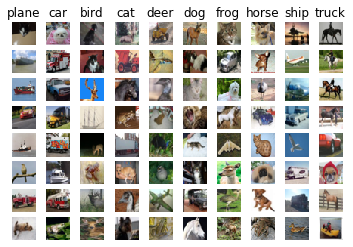

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [24]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = [80,100,120]
learning_rates = [7e-1,7.5e-1,8e-1,8.5e-1]
reg = [1e-5,5e-5,1e-4,5e-4,1e-3]

num_classes = 10

best_net = None
val_best = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in hidden_dim:
    for j in learning_rates:
        for k in reg:
            net = TwoLayerNet(input_dim, i, num_classes)
            net.train(X_train_feats,y_train,X_val_feats,
                      y_val,learning_rate=j,reg=k,num_iters=1200,verbose=True)
            
            
            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            if val_acc > val_best:
                val_best = val_acc
                best_net = net
            print('hidden_size : %f   learning_rate : %f   reg : %f' % (i,j,k))
            print('Validation accuracy: ', val_acc)
            print('-'*80)
            print('-'*80)
            


pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.536038
iteration 200 / 1200: loss 1.271186
iteration 300 / 1200: loss 1.330507
iteration 400 / 1200: loss 1.159059
iteration 500 / 1200: loss 1.336150
iteration 600 / 1200: loss 1.158487
iteration 700 / 1200: loss 1.264521
iteration 800 / 1200: loss 1.193808
iteration 900 / 1200: loss 1.182910
iteration 1000 / 1200: loss 1.207707
iteration 1100 / 1200: loss 1.168063
hidden_size : 80.000000   learning_rate : 0.700000   reg : 0.000010
Validation accuracy:  0.551
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.382303
iteration 200 / 1200: loss 1.394883
iteration 300 / 1200: loss 1.249894
iteration 400 / 1200: loss 1.229278
iteration 500 / 1200: loss 1.244872
iteration 600 / 1200: loss 1.193653
iteration 700 / 1200: loss 1.229052
iteration 800 / 1200: lo

iteration 100 / 1200: loss 1.699245
iteration 200 / 1200: loss 1.515421
iteration 300 / 1200: loss 1.251828
iteration 400 / 1200: loss 1.190909
iteration 500 / 1200: loss 1.313353
iteration 600 / 1200: loss 1.389197
iteration 700 / 1200: loss 1.258990
iteration 800 / 1200: loss 1.288931
iteration 900 / 1200: loss 1.240692
iteration 1000 / 1200: loss 0.959140
iteration 1100 / 1200: loss 1.070427
hidden_size : 80.000000   learning_rate : 0.800000   reg : 0.000100
Validation accuracy:  0.542
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.413048
iteration 200 / 1200: loss 1.419518
iteration 300 / 1200: loss 1.351002
iteration 400 / 1200: loss 1.086542
iteration 500 / 1200: loss 1.198179
iteration 600 / 1200: loss 1.435452
iteration 700 / 1200: loss 1.219472
iteration 800 / 1200: loss 1.252051
iteration 900 / 1200: 

iteration 100 / 1200: loss 1.539637
iteration 200 / 1200: loss 1.539797
iteration 300 / 1200: loss 1.354659
iteration 400 / 1200: loss 1.526590
iteration 500 / 1200: loss 1.287346
iteration 600 / 1200: loss 1.307282
iteration 700 / 1200: loss 1.222149
iteration 800 / 1200: loss 1.409924
iteration 900 / 1200: loss 1.227634
iteration 1000 / 1200: loss 1.255616
iteration 1100 / 1200: loss 1.338558
hidden_size : 80.000000   learning_rate : 0.900000   reg : 0.001000
Validation accuracy:  0.551
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.440723
iteration 200 / 1200: loss 1.475202
iteration 300 / 1200: loss 1.390470
iteration 400 / 1200: loss 1.335763
iteration 500 / 1200: loss 1.345972
iteration 600 / 1200: loss 1.157536
iteration 700 / 1200: loss 1.144677
iteration 800 / 1200: loss 1.194097
iteration 900 / 1200: 

iteration 100 / 1200: loss 1.352212
iteration 200 / 1200: loss 1.359416
iteration 300 / 1200: loss 1.333220
iteration 400 / 1200: loss 1.164729
iteration 500 / 1200: loss 1.105519
iteration 600 / 1200: loss 1.236048
iteration 700 / 1200: loss 1.106716
iteration 800 / 1200: loss 1.095209
iteration 900 / 1200: loss 1.109512
iteration 1000 / 1200: loss 1.032710
iteration 1100 / 1200: loss 0.885605
hidden_size : 100.000000   learning_rate : 0.800000   reg : 0.000050
Validation accuracy:  0.581
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.453033
iteration 200 / 1200: loss 1.417063
iteration 300 / 1200: loss 1.238171
iteration 400 / 1200: loss 1.313305
iteration 500 / 1200: loss 1.164963
iteration 600 / 1200: loss 1.236339
iteration 700 / 1200: loss 1.184647
iteration 800 / 1200: loss 1.319670
iteration 900 / 1200:

iteration 100 / 1200: loss 1.457548
iteration 200 / 1200: loss 1.280824
iteration 300 / 1200: loss 1.387013
iteration 400 / 1200: loss 1.297445
iteration 500 / 1200: loss 1.188271
iteration 600 / 1200: loss 1.325542
iteration 700 / 1200: loss 1.412432
iteration 800 / 1200: loss 1.184444
iteration 900 / 1200: loss 1.329971
iteration 1000 / 1200: loss 1.125500
iteration 1100 / 1200: loss 1.226563
hidden_size : 100.000000   learning_rate : 0.900000   reg : 0.000500
Validation accuracy:  0.575
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.566973
iteration 200 / 1200: loss 1.406997
iteration 300 / 1200: loss 1.478526
iteration 400 / 1200: loss 1.308325
iteration 500 / 1200: loss 1.368290
iteration 600 / 1200: loss 1.389222
iteration 700 / 1200: loss 1.368919
iteration 800 / 1200: loss 1.275547
iteration 900 / 1200:

iteration 100 / 1200: loss 1.428564
iteration 200 / 1200: loss 1.360974
iteration 300 / 1200: loss 1.336990
iteration 400 / 1200: loss 1.450319
iteration 500 / 1200: loss 1.172663
iteration 600 / 1200: loss 1.072414
iteration 700 / 1200: loss 1.155180
iteration 800 / 1200: loss 1.150611
iteration 900 / 1200: loss 1.169204
iteration 1000 / 1200: loss 1.000989
iteration 1100 / 1200: loss 1.088914
hidden_size : 120.000000   learning_rate : 0.800000   reg : 0.000010
Validation accuracy:  0.555
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 1.463333
iteration 200 / 1200: loss 1.342554
iteration 300 / 1200: loss 1.368134
iteration 400 / 1200: loss 1.378810
iteration 500 / 1200: loss 1.208263
iteration 600 / 1200: loss 1.129267
iteration 700 / 1200: loss 1.198843
iteration 800 / 1200: loss 1.194920
iteration 900 / 1200:

iteration 100 / 1200: loss 1.345430
iteration 200 / 1200: loss 1.377516
iteration 300 / 1200: loss 1.220369
iteration 400 / 1200: loss 1.320279
iteration 500 / 1200: loss 1.210430
iteration 600 / 1200: loss 1.225402
iteration 700 / 1200: loss 1.397238
iteration 800 / 1200: loss 1.336459
iteration 900 / 1200: loss 1.075745


KeyboardInterrupt: 

In [25]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.573
